In [458]:
## imports
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import statsmodels.tsa.ar_model
from sklearn.metrics import mean_squared_error
import numpy as np
from math import sqrt

In [959]:
## loading and reading in csv dataset using pandas
brazil_df = pd.read_csv('covid19_brazil_new.csv')
brazil_df.head()

,date,region,state,cases,deaths
0,2020-02-26,Sudeste,São Paulo,1,0
1,2020-02-27,Sudeste,São Paulo,1,0
2,2020-02-28,Sudeste,São Paulo,1,0
3,2020-02-29,Sudeste,São Paulo,2,0
4,2020-03-01,Sudeste,São Paulo,2,0


In [960]:
brazil_df['date'] = pd.to_datetime(brazil_df['date'])

In [961]:
brazil_df_sort = brazil_df.sort_values(by = 'date')

In [962]:
date_cases = {}
date_cases_keys = brazil_df_sort['date']

final_keys = []
for date in date_cases_keys:
    if date not in final_keys:
        final_keys.append(date)
date_cases_values = []

test_d = '2/24/20'

for d in date_cases_keys:
    if d != test_d:
        value = brazil_df_sort[brazil_df_sort['date'] == d]['cases'].sum()
        date_cases_values.append(value)
        test_d = d

new_columns = list(zip(final_keys, date_cases_values))
new_df = pd.DataFrame(new_columns, columns = ['Date', 'Obs Cases'])

In [963]:
date_cases = {final_keys[i]: date_cases_values[i] for i in range(len(final_keys))} 
date_case = pd.DataFrame.from_dict(date_cases, orient= 'index', columns = ['Cases'])

In [964]:
brazil_df_sort['date'] = pd.to_datetime(brazil_df_sort['date'])

In [965]:
dates_list = []
for date in brazil_df_sort['date']:
    if date not in dates_list:
        dates_list.append(date)
date_cases_2 = {dates_list[i]: date_cases_values[i] for i in range(len(dates_list))} 
date_case_2 = pd.DataFrame.from_dict(date_cases_2, orient= 'index', columns = ['Cases'])

In [1114]:
dates_cases = list(zip(dates_list, date_case_2['Cases']))
compiled = pd.DataFrame(dates_cases, columns = ['dates', 'cases'])
compiled['region'] = np.nan
compiled['state'] = np.nan
compiled['newCases'] = np.nan

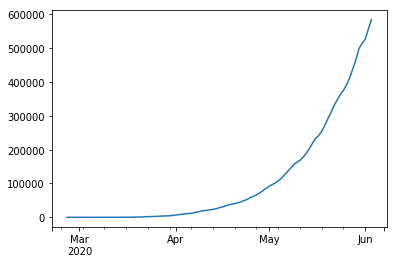

In [967]:
date_case_2['Cases'].plot()
plt.show()

In [969]:
def est_trend(data, n, new_df):
    ##Estimating Trend
    data_est = np.log(data)

    
    ##calculating moving averages

    movingAvg = data_est.rolling(window=12).mean()
    movingStd = data_est.rolling(window = 12).std()
    
    #fig, axs = plt.subplots(3)
    
    plt.figure(1)
    plt.plot(data_est)
    plt.plot(movingAvg, color = 'red')
    
    ##diff between moving averages and actual cases
    diff = data_est - movingAvg
    ##remove null values
    diff.dropna(inplace = True)
    
    plt.figure(2)
    plt.plot(diff)
    plt.plot(movingAvg, color = 'red', label = 'MovingAvg')
    plt.plot(movingStd, color = 'black', label = 'MovingStd')
    

    ##reperform Dickey-Fuller Test on transformed data to check stationarity
    print("Results of Dickey-Fuller Test")
    test = adfuller(data_est['Cases'], autolag = "AIC")

    output = pd.Series(test[0:4], index = ['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for k,v in test[4].items():
        output['Critical Value (%s)'%k] = v
    
    print(output)
    
    ##calculate weighted average
    weight_avg = data_est.ewm(halflife = 12, min_periods = 0, adjust = True).mean()
    
    ##exponentiate to reverse log transformation (e^x)
    #data_est = np.exp(data_est)
    
    ##prediction 
    
   
    from statsmodels.tsa.ar_model import AR
    from sklearn.metrics import r2_score

    ##split data into train and test
    X = (data_est).dropna()
    n = int(np.floor(0.2 * len(X)))
    train = X[1: len(X) - n]
    test = X
    
    ##fit and train model using split data
    model = AR(train)
    model_fitted = model.fit()
    print('the lag value is: %s' % model_fitted.k_ar)
    lag = model_fitted.k_ar
    lag = lag + 1
    
    predict = model_fitted.predict(start = lag, end = len(test) , dynamic = False)

    ##plot predicted data vs. true/observed data
    plt.figure(3)
    plt.title("Predicted vs. Observed Cases (log scale)")
    plt.legend()
    plt.plot(data_est, color = 'blue')
    plt.plot(predict, color = 'red')
    
    orig = np.exp(predict)
    plt.figure(4)
    plt.title("Predicted vs. Observed Cases")
    plt.plot(data, color = 'blue')
    plt.plot(orig, color = 'red')
    
    
    ## error analysis - try a few different methods
    
    #r^2 error analysis - not metric to show if model is a good future predictor, but shows if model is good fit to 
    #observed data
    r2_err = r2_score(data_est.tail(len(X) - lag +1), predict)
    print('R^2 error: %s' % r2_err)
    
    #mean absolute error - measuring prediction errors because prediction in same unit as original (avg forecast error)
    from sklearn.metrics import mean_absolute_error
    mae = mean_absolute_error(data_est.tail(len(X) - lag + 1), predict)
    print('Mean Absolute Error: %s' % mae)
    
    #root mean squared error - sqrt average of square of forecase error (mse): basically same as mse but when dealing
    #with prediction in same unit as original - how concentrated is data around line of best fit
    from sklearn.metrics import mean_squared_error
    mse = mean_squared_error(predict, data_est.tail(len(X) - lag + 1))
    print('Mean squared error: %s' % mse)
    
    rmse = np.sqrt(mse)
    print('Root mean squared error: %s' % rmse)
    
    new_pred = [np.nan] * (lag - 1)
    new_pred = new_pred + list(predict)
    
    new_df['Y_predicted'] = new_pred
    new_df['Y_original'] = list(data_est['Cases'])
    
    return new_df

/Users/anyaaggarwal/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
No handles with labels found to put in legend.


Results of Dickey-Fuller Test
Test Statistic                 -3.175466
p-value                         0.021449
#Lags Used                      8.000000
Number of Observations Used    90.000000
Critical Value (1%)            -3.505190
Critical Value (5%)            -2.894232
Critical Value (10%)           -2.584210
dtype: float64
the lag value is: 11
R^2 error: 0.9864878001936823
Mean Absolute Error: 0.25340023724719496
Mean squared error: 0.09705420332354855
Root mean squared error: 0.311535236086624


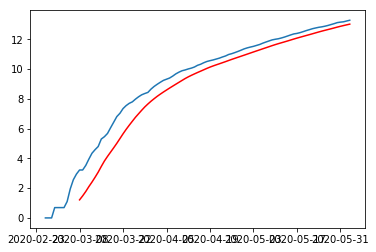

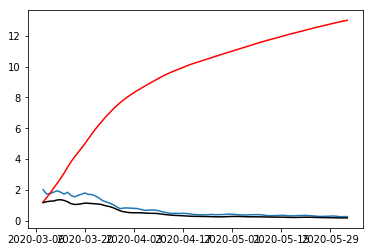

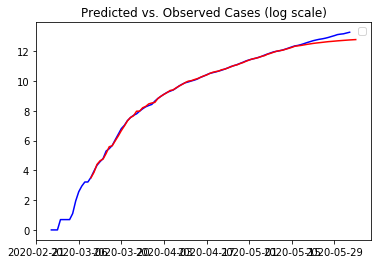

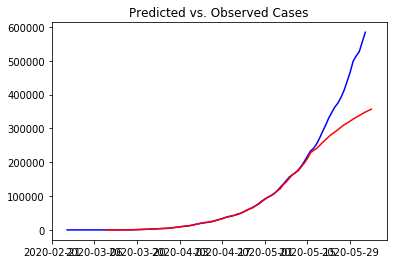

In [970]:
comb = est_trend(date_case_2, 40, compiled)

In [971]:
comb['Error'] = np.nan
n = 0
while (n < len(comb['Y_predicted'])):
    error = (comb['Y_predicted'][n] - comb['Y_original'][n]) / comb['Y_original'][n]
    comb['Error'][n] = error
    n += 1
print("Average Percent Error: %s" % np.mean(comb['Error']))
print(np.sum(comb['Error'][18:]) / (79-18))

/Users/anyaaggarwal/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


Average Percent Error: 0.0281302364492132
0.02268800445423111


## Moving Average Prediction

In [994]:
from numpy import mean
log_data = np.log(date_cases_values)
window = 2

In [995]:
log_past = [log_data[i] for i in range(window)]
log_test = ([log_data[i] for i in range(window, len(log_data))])

log_predictions = list()
dates = final_keys[2:]

In [996]:
for t in range(len(log_test)):
    length = len(log_past)
    yhat = mean([log_past[i] for i in range(length-window, length)])
    obs = log_test[t]
    log_predictions.append(yhat)
    log_past.append(obs)

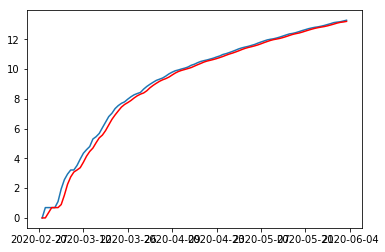

In [997]:
plt.plot(dates, log_test)
plt.plot(dates, log_predictions, color = 'red')
plt.show()

In [998]:
test = np.exp(log_test)
predictions = np.exp(log_predictions)
predictions = np.delete(predictions, 0)

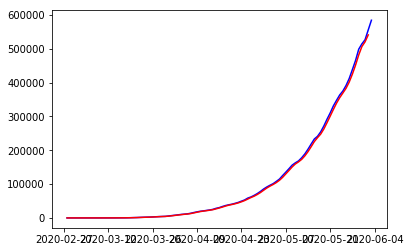

In [999]:
plt.plot(dates, test, color = 'blue')
plt.plot(dates[:-1], predictions, color ='red')
plt.show()

In [1000]:
errors = list()
for i in range(len(predictions)):
    err = abs(test[i] - predictions[i])/test[i]
    errors.append(err)
print(mean(errors))

0.06407532715880283


## ARIMA Modeling

In [1001]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [1002]:
def arima_est(data, n, new_df):
    ##Estimating Trend
    data_est = np.log(data)

    
    ##calculating moving averages

    movingAvg = data_est.rolling(window=12).mean()
    movingStd = data_est.rolling(window = 12).std()
    
    #fig, axs = plt.subplots(3)
    
    ##diff between moving averages and actual cases
    diff = data_est - movingAvg
    ##remove null values
    diff.dropna(inplace = True)
    

    ##reperform Dickey-Fuller Test on transformed data to check stationarity
    print("Results of Dickey-Fuller Test")
    test = adfuller(data_est['Cases'], autolag = "AIC")

    output = pd.Series(test[0:4], index = ['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for k,v in test[4].items():
        output['Critical Value (%s)'%k] = v
    
    print(output)
    
    ##calculate weighted average
    weight_avg = data_est.ewm(halflife = 12, min_periods = 0, adjust = True).mean()
    
    ##exponentiate to reverse log transformation (e^x)
    #data_est = np.exp(data_est)
    
    ##prediction 
    
   
    from statsmodels.tsa.arima_model import ARIMA
    from sklearn.metrics import r2_score

    ##split data into train and test
    X = (data_est).dropna()
    n = int(np.floor(0.09 * len(X)))
    train = X[0: len(X) - n]
    test = X
    
    ##fit and train model using split data
    lag = 11
    model2 = ARIMA(train, order = (1,1,2))
    model2_fitted = model2.fit(disp = False)
    
    yhat = model2_fitted.predict(lag, len(data_est) - 1, typ = 'levels')

    ##plot predicted data vs. true/observed data
    plt.figure(1)
    plt.title("Predicted vs. Observed Cases (log scale)")
    plt.legend()
    plt.plot(data_est, color = 'blue')
    plt.plot(yhat, color = 'red')
    
    yhat_case = np.exp(yhat)
    plt.figure(2)
    plt.title("Predicted vs. Observed Cases")
    plt.plot(data, color = 'blue')
    plt.plot(yhat_case, color = 'red')
    
    
    ## error analysis - try a few different methods
    
    #r^2 error analysis - not metric to show if model is a good future predictor, but shows if model is good fit to 
    #observed data
    r2_err = r2_score(data_est.tail(len(X) - lag), yhat)
    print('R^2 error: %s' % r2_err)
    
    #mean absolute error - measuring prediction errors because prediction in same unit as original (avg forecast error)
    from sklearn.metrics import mean_absolute_error
    mae = mean_absolute_error(data_est.tail(len(X) - lag), yhat)
    print('Mean Absolute Error: %s' % mae)
    
    #root mean squared error - sqrt average of square of forecase error (mse): basically same as mse but when dealing
    #with prediction in same unit as original - how concentrated is data around line of best fit
    from sklearn.metrics import mean_squared_error
    mse = mean_squared_error(yhat, data_est.tail(len(X) - lag))
    print('Mean squared error: %s' % mse)
    
    rmse = np.sqrt(mse)
    print('Root mean squared error: %s' % rmse)
    
    new_pred = [np.nan] * (lag )
    new_pred = new_pred + list(yhat_case)
    
    new_df['Y_predicted'] = new_pred
    new_df['Y_original'] = list(data['Cases'])
    
    return new_df

/Users/anyaaggarwal/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/anyaaggarwal/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
No handles with labels found to put in legend.


Results of Dickey-Fuller Test
Test Statistic                 -3.175466
p-value                         0.021449
#Lags Used                      8.000000
Number of Observations Used    90.000000
Critical Value (1%)            -3.505190
Critical Value (5%)            -2.894232
Critical Value (10%)           -2.584210
dtype: float64
R^2 error: 0.9992005422773119
Mean Absolute Error: 0.05071185868123302
Mean squared error: 0.005742272426290699
Root mean squared error: 0.0757777831972584


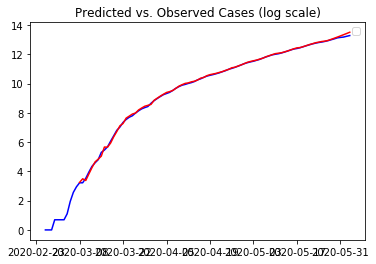

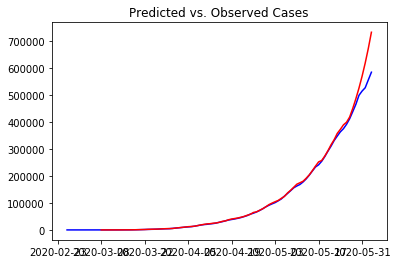

In [1003]:
compiled_pred = arima_est(date_case_2,40, compiled)

In [1004]:
compiled_pred['Error'] = np.nan
n = 0
while (n < len(compiled_pred['Y_predicted'])):
    error = abs(compiled_pred['Y_predicted'][n] - compiled_pred['Y_original'][n]) / compiled_pred['Y_original'][n]
    compiled_pred['Error'][n] = error
    n += 1
print("Average Percent Error: %s" % np.mean(compiled_pred['Error']))

/Users/anyaaggarwal/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


Average Percent Error: 0.052031276220371264


# Arima with surrounding data

In [1047]:
def close_arima(data, new_df):
    ##Estimating Trend
    data_est = np.log(data)

    
    ##calculating moving averages

    movingAvg = data_est.rolling(window=12).mean()
    movingStd = data_est.rolling(window = 12).std()
    
    #fig, axs = plt.subplots(3)
    
    ##diff between moving averages and actual cases
    diff = data_est - movingAvg
    ##remove null values
    diff.dropna(inplace = True)
    

    ##reperform Dickey-Fuller Test on transformed data to check stationarity
    print("Results of Dickey-Fuller Test")
    test = adfuller(data_est['Cases'], autolag = "AIC")

    output = pd.Series(test[0:4], index = ['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for k,v in test[4].items():
        output['Critical Value (%s)'%k] = v
    
    print(output)
    
    ##calculate weighted average
    weight_avg = data_est.ewm(halflife = 12, min_periods = 0, adjust = True).mean()
    
    ##exponentiate to reverse log transformation (e^x)
    #data_est = np.exp(data_est)
    
    ##prediction 
    
   
    from statsmodels.tsa.arima_model import ARIMA
    from sklearn.metrics import r2_score

    ##split data into train and test
    X = (data_est).dropna()
    n = 21
    train = X[len(date_case_2) - n:]
    test = X
    
    ##fit and train model using split data
    lag = 7
    model2 = ARIMA(train, order = (2,1,1))
    model2_fitted = model2.fit(disp = False)
    
    yhat = model2_fitted.predict(1, len(train) - 1, typ = 'levels')

    ##plot predicted data vs. true/observed data
    plt.figure(1)
    plt.title("Predicted vs. Observed Cases (log scale)")
    plt.legend()
    plt.plot(data_est, color = 'blue')
    plt.plot(yhat, color = 'red')
    
    yhat_case = np.exp(yhat)
    plt.figure(2)
    plt.title("Predicted vs. Observed Cases")
    plt.plot(data, color = 'blue')
    plt.plot(yhat_case, color = 'red')
    
    
    ## error analysis - try a few different methods
    #r^2 error analysis - not metric to show if model is a good future predictor, but shows if model is good fit to 
    #observed data
    r2_err = r2_score(train[1:], yhat)
    print('R^2 error: %s' % r2_err)
    
    #mean absolute error - measuring prediction errors because prediction in same unit as original (avg forecast error)
    from sklearn.metrics import mean_absolute_error
    mae = mean_absolute_error(train[1:], yhat)
    print('Mean Absolute Error: %s' % mae)
    
    #root mean squared error - sqrt average of square of forecase error (mse): basically same as mse but when dealing
    #with prediction in same unit as original - how concentrated is data around line of best fit
    from sklearn.metrics import mean_squared_error
    mse = mean_squared_error(yhat, train[1:])
    print('Mean squared error: %s' % mse)
    
    rmse = np.sqrt(mse)
    print('Root mean squared error: %s' % rmse)
    
    new_pred = [np.nan] * (len(data_est) - len(yhat))
    nan = [np.nan] * (len(data_est) - len(train))
    new_pred = new_pred + list(yhat_case)
    
    new_df['Y_predicted'] = new_pred
    new_df['Y_original'] = list(data['Cases'])
    
    
    return new_df

/Users/anyaaggarwal/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/anyaaggarwal/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
No handles with labels found to put in legend.


Results of Dickey-Fuller Test
Test Statistic                 -3.175466
p-value                         0.021449
#Lags Used                      8.000000
Number of Observations Used    90.000000
Critical Value (1%)            -3.505190
Critical Value (5%)            -2.894232
Critical Value (10%)           -2.584210
dtype: float64
R^2 error: 0.998238383290151
Mean Absolute Error: 0.010582752810405526
Mean squared error: 0.00015880191194524298
Root mean squared error: 0.012601663062677203


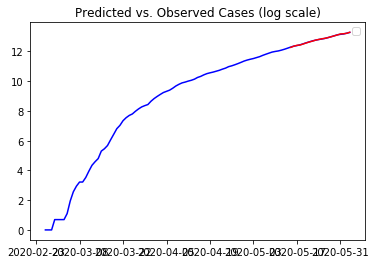

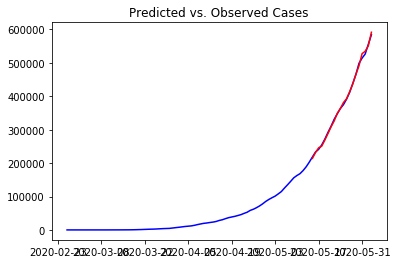

In [1048]:
test_comp = close_arima(date_case_2, compiled)

In [1049]:
test_comp['Error'] = np.nan
n = 0
while (n < len(test_comp['Y_predicted'])):
    if (test_comp['Y_predicted'][n]):
        error = abs(test_comp['Y_predicted'][n] - test_comp['Y_original'][n]) / test_comp['Y_original'][n]
        test_comp['Error'][n] = error
        n += 1
print("Average Percent Error: %s" % (np.mean(test_comp['Error']) * 100) + '%')

/Users/anyaaggarwal/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Average Percent Error: 1.0590299648694355%


In [1078]:
def test(data, new_df):
    ##Estimating Trend
    data_est = np.log(data)

    
    ##calculating moving averages

    movingAvg = data_est.rolling(window=12).mean()
    movingStd = data_est.rolling(window = 12).std()
    
    #fig, axs = plt.subplots(3)
    
    ##diff between moving averages and actual cases
    diff = data_est - movingAvg
    ##remove null values
    diff.dropna(inplace = True)
    

    ##reperform Dickey-Fuller Test on transformed data to check stationarity
    print("Results of Dickey-Fuller Test")
    test = adfuller(data_est['Cases'], autolag = "AIC")

    output = pd.Series(test[0:4], index = ['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for k,v in test[4].items():
        output['Critical Value (%s)'%k] = v
    
    print(output)
    
    ##calculate weighted average
    weight_avg = data_est.ewm(halflife = 12, min_periods = 0, adjust = True).mean()
    
    ##exponentiate to reverse log transformation (e^x)
    #data_est = np.exp(data_est)
    
    ##prediction 
    
   
    from statsmodels.tsa.arima_model import ARIMA
    from sklearn.metrics import r2_score

    ##split data into train and test
    X = (data_est).dropna()
    n = 8
    train = X[len(date_case_2) - 14: len(date_case_2) - 7]
    test = X
    
    ##fit and train model using split data
    lag = 7
    model2 = ARIMA(train, order = (2,1,1))
    model2_fitted = model2.fit(disp = False)
    
    yhat = model2_fitted.predict(1, len(train) + 6, typ = 'levels')
    #print(yhat)

    ##plot predicted data vs. true/observed data
    plt.figure(1)
    plt.title("Predicted vs. Observed Cases (log scale)")
    plt.legend()
    plt.plot(data_est, color = 'blue')
    plt.plot(yhat, color = 'red')
    
    yhat_case = np.exp(yhat)
    plt.figure(2)
    plt.title("Predicted vs. Observed Cases")
    plt.plot(data, color = 'blue')
    plt.plot(yhat_case, color = 'red')
    
    return(yhat_case, data[len(data) - 13:])

/Users/anyaaggarwal/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/anyaaggarwal/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/anyaaggarwal/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/ar_model.py:765: RuntimeWarning: divide by zero encountered in log
  return np.log(self.sigma2) + (1 + self.df_model) * np.log(nobs)/nobs
No handles with labels found to put in legend.


Results of Dickey-Fuller Test
Test Statistic                 -3.175466
p-value                         0.021449
#Lags Used                      8.000000
Number of Observations Used    90.000000
Critical Value (1%)            -3.505190
Critical Value (5%)            -2.894232
Critical Value (10%)           -2.584210
dtype: float64


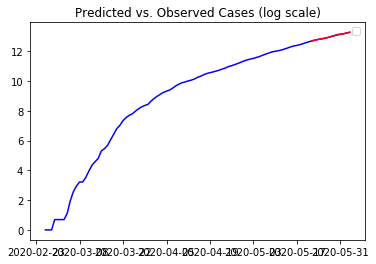

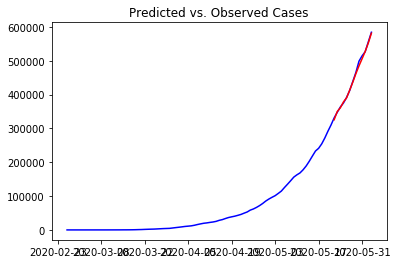

In [1079]:
predict, orig = test(date_case_2, compiled)

In [1080]:
error = []
predict = list(predict)
orig = list(orig['Cases'])
x = 0
while (x < len(predict)):
    err = abs(predict[x] - orig[x]) / orig[x]
    error.append(err)
    x += 1
print("Avg Percent Error: %s"% (np.mean(error) * 100) + "%")

Avg Percent Error: 0.8582215610904467%


# Deaths Analysis

In [1084]:
date_cases = {}
date_cases_keys = brazil_df_sort['date']

final_keys = []
for date in date_cases_keys:
    if date not in final_keys:
        final_keys.append(date)
date_cases_values_d = []

test_d = '2/24/20'

for d in date_cases_keys:
    if d != test_d:
        value_d = brazil_df_sort[brazil_df_sort['date'] == d]['deaths'].sum()
        date_cases_values_d.append(value_d)
        test_d = d

new_columns_d = list(zip(final_keys, date_cases_values_d))
new_df_death = pd.DataFrame(new_columns_d, columns = ['Date', 'Obs Deaths'])

In [1086]:
date_cases_d = {final_keys[i]: date_cases_values_d[i] for i in range(len(final_keys))} 
date_case_d = pd.DataFrame.from_dict(date_cases_d, orient= 'index', columns = ['Deaths'])

dates_list = []
for date in brazil_df_sort['date']:
    if date not in dates_list:
        dates_list.append(date)
date_cases_death = {dates_list[i]: date_cases_values_d[i] for i in range(len(dates_list))} 
date_case_death = pd.DataFrame.from_dict(date_cases_death, orient= 'index', columns = ['Deaths'])

In [1121]:
compiled['obs_deaths'] = list(date_case_death['Deaths'])

In [1122]:
def deaths(data, new_df):
    ##Estimating Trend
    data_est = np.log(data)

    
    ##calculating moving averages

    movingAvg = data_est.rolling(window=12).mean()
    movingStd = data_est.rolling(window = 12).std()
    
    #fig, axs = plt.subplots(3)
    
    ##diff between moving averages and actual cases
    diff = data_est - movingAvg
    ##remove null values
    diff.dropna(inplace = True)
    
    
    ##calculate weighted average
    weight_avg = data_est.ewm(halflife = 12, min_periods = 0, adjust = True).mean()
    
    ##exponentiate to reverse log transformation (e^x)
    #data_est = np.exp(data_est)
    
    ##prediction 
    
   
    from statsmodels.tsa.arima_model import ARIMA
    from sklearn.metrics import r2_score

    ##split data into train and test
    X = (data_est).dropna()
    n = 21
    train = X[len(date_case_death) - n:]
    test = X
    
    ##fit and train model using split data
    lag = 7
    model2 = ARIMA(train, order = (2,1,1))
    model2_fitted = model2.fit(disp = False)
    
    yhat = model2_fitted.predict(1, len(train) - 1, typ = 'levels')

    ##plot predicted data vs. true/observed data
    plt.figure(1)
    plt.title("Predicted vs. Observed Cases (log scale)")
    plt.legend()
    plt.plot(data_est, color = 'blue')
    plt.plot(yhat, color = 'red')
    
    yhat_case = np.exp(yhat)
    plt.figure(2)
    plt.title("Predicted vs. Observed Cases")
    plt.plot(data, color = 'blue')
    plt.plot(yhat_case, color = 'red')
    
    death_pred = [np.nan] * (len(data_est) - len(yhat))
    death_pred = death_pred + list(yhat_case)
    
    new_df['death_predicted'] = death_pred
    
    return new_df

/Users/anyaaggarwal/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/anyaaggarwal/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/anyaaggarwal/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
No handles with labels found to put in legend.


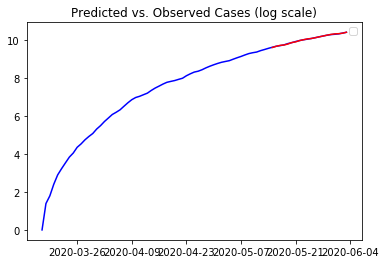

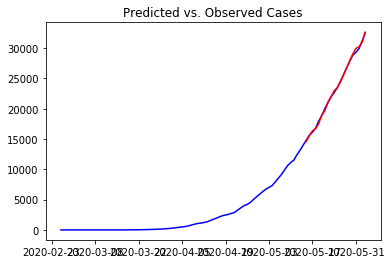

In [1123]:
death_df = deaths(date_case_death, compiled)

In [1125]:
death_df['death_error'] = np.nan
n = 0
while (n < len(death_df['death_predicted'])):
    if (death_df['death_predicted'][n]):
        error = abs(death_df['death_predicted'][n] - death_df['obs_deaths'][n]) / death_df['obs_deaths'][n]
        death_df['death_error'][n] = error
        n += 1
print("Average Percent Error: %s" % (np.mean(death_df['death_error']) * 100) + '%')

/Users/anyaaggarwal/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Average Percent Error: 0.8221697100107719%


# State Analysis

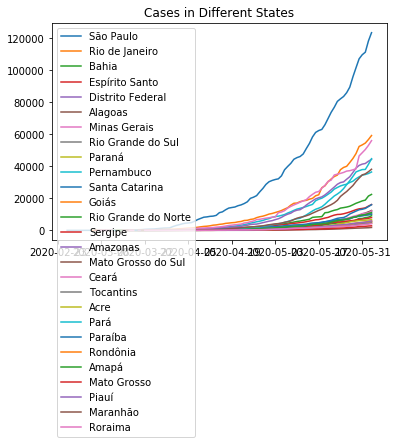

In [1159]:
states = list(brazil_df_sort['state'].unique())
plot_num = 1

for s in states:
    cases = list(brazil_df_sort[brazil_df_sort['state'] == s]['cases'])
    dates = list(brazil_df_sort[brazil_df_sort['state'] == s]['date'])
    plt.plot(dates, cases, label = '%s' %s)
plt.title('Cases in Different States')
plt.legend()

State: São Paulo
Results of Dickey-Fuller Test
Test Statistic                -6.532371e+00
p-value                        9.797271e-09
#Lags Used                     7.000000e+00
Number of Observations Used    9.100000e+01
Critical Value (1%)           -3.504343e+00
Critical Value (5%)           -2.893866e+00
Critical Value (10%)          -2.584015e+00
dtype: float64


/Users/anyaaggarwal/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/anyaaggarwal/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
No handles with labels found to put in legend.


R^2 error: 0.9968322567831239
Mean Absolute Error: 0.010126730474576373
Mean squared error: 0.00016731760702867624
Root mean squared error: 0.012935130731023797


/Users/anyaaggarwal/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/anyaaggarwal/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/anyaaggarwal/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
No handles with labels found to put in legend.


Average Percent Error São Paulo: 1%
State: Rio de Janeiro
Results of Dickey-Fuller Test
Test Statistic                 -2.160307
p-value                         0.220966
#Lags Used                     11.000000
Number of Observations Used    79.000000
Critical Value (1%)            -3.515977
Critical Value (5%)            -2.898886
Critical Value (10%)           -2.586694
dtype: float64
R^2 error: 0.9812710267601886
Mean Absolute Error: 0.019012313319707985
Mean squared error: 0.0005438800103416374
Root mean squared error: 0.023321235180445255


/Users/anyaaggarwal/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Average Percent Error Rio de Janeiro: 1%


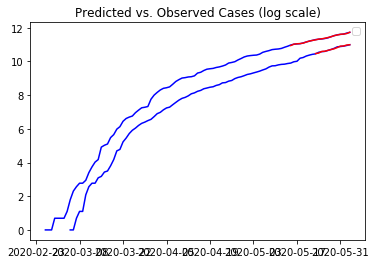

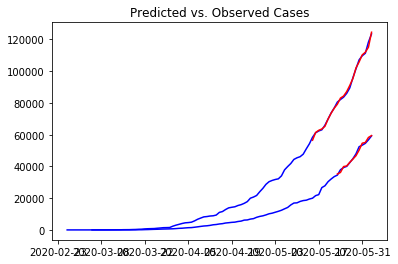

In [1167]:
for s in states[0:2]:
    cases = list(brazil_df_sort[brazil_df_sort['state'] == s]['cases'])
    dates = list(brazil_df_sort[brazil_df_sort['state'] == s]['date'])
    case_dict = {dates[i]: cases[i] for i in range(len(dates))} 
    case_df = pd.DataFrame.from_dict(case_dict, orient= 'index', columns = ['Cases'])
    
    state_comp = list(zip(dates, case_df['Cases']))
    state_compiled = pd.DataFrame(state_comp, columns = ['dates', 'cases'])

    print('State: %s' %s)
    state_df = close_arima(case_df, state_compiled)
    
    state_df['Error'] = np.nan
    n = 0
    while (n < len(state_df['Y_predicted'])):
        if (state_df['Y_predicted'][n]):
            error = abs(state_df['Y_predicted'][n] - state_df['Y_original'][n]) / state_df['Y_original'][n]
            state_df['Error'][n] = error
            n += 1
    print("Average Percent Error %s: %d" % (s, (np.mean(state_df['Error']) * 100)) + '%')